# 1. CONFIGURACIÓN INICIAL Y CLONADO

In [6]:
!mkdir -p data models results notebooks

# Clonar el repositorio base si no lo tienes local
!git clone https://github.com/Gerardo-cursos/objetos_salon.git data_base
!cp -r data_base/data/processed data/

import os, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, Model, Input
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

IMG_SIZE = (160,160)
LATENT_DIM = 64
BATCH_SIZE = 32
EPOCHS_AE = 40
EPOCHS_CLS = 30
SEED = 42

DATA_DIR = "processed"
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

Cloning into 'data_base'...
remote: Enumerating objects: 2496, done.
remote: Counting objects: 100% (644/644), done.
remote: Compressing objects: 100% (496/496), done.
remote: Total 2496 (delta 195), reused 367 (delta 148), pack-reused 1852 (from 5)
Receiving objects: 100% (2496/2496), 1.24 GiB | 24.40 MiB/s, done.
Resolving deltas: 100% (456/456), done.
Updating files: 100% (1764/1764), done.
cp: cannot stat 'data_base/data/processed': No such file or directory


# 2 CARGA DE DATOS Y DIVISIÓN TRAIN/VAL/TEST

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.3,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.3,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_batches = int(0.5 * len(val_test_ds))
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Clases:", class_names)

Found 1619 files belonging to 7 classes.
Using 1134 files for training.
Found 1619 files belonging to 7 classes.
Using 485 files for validation.
Clases: ['cpu', 'mesa', 'mouse', 'nada', 'pantalla', 'silla', 'teclado']


# 3. NORMALIZACIÓN Y AUMENTACIÓN DE DATOS

In [8]:
normalizer = layers.Rescaling(1./255)
data_augment = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.25),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.2),
])

def prep_autoenc(x, y):
    x = normalizer(data_augment(x))
    return x, x

def prep_classif(x, y):
    x = normalizer(data_augment(x))
    return x, y

train_ae = train_ds.map(prep_autoenc).cache().prefetch(tf.data.AUTOTUNE)
val_ae   = val_ds.map(prep_autoenc).cache().prefetch(tf.data.AUTOTUNE)
train_cls = train_ds.map(prep_classif).cache().prefetch(tf.data.AUTOTUNE)
val_cls   = val_ds.map(prep_classif).cache().prefetch(tf.data.AUTOTUNE)
test_cls  = test_ds.map(prep_classif).cache().prefetch(tf.data.AUTOTUNE)

# 4. DEFINICIÓN DEL MODELO CNN SUPERVISADO

## 4.1 AutoEnconder obsoleto

In [ ]:
def build_encoder(img_size=IMG_SIZE, latent_dim=LATENT_DIM):
    inputs = layers.Input(shape=img_size + (3,))
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    z = layers.Dense(latent_dim, activation=None, name="latent",
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    return keras.Model(inputs, z, name="encoder")

def build_decoder(img_size=IMG_SIZE, latent_dim=LATENT_DIM):
    h, w = img_size[0]//16, img_size[1]//16
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(h*w*256, activation="relu")(inputs)
    x = layers.Reshape((h, w, 256))(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    outputs = layers.Conv2DTranspose(3, 3, strides=2, padding="same", activation="sigmoid")(x)
    return keras.Model(inputs, outputs, name="decoder")

encoder = build_encoder()
decoder = build_decoder()

inp = keras.Input(shape=IMG_SIZE + (3,))
z = encoder(inp)
recon = decoder(z)
autoencoder = keras.Model(inp, recon, name="autoencoder")

autoencoder.compile(optimizer=keras.optimizers.Adam(1e-4), loss="mse")
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 64)             │    13,251,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 224, 224, 3)    │     3,649,603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,900,675 (64.47 MB)

 Trainable params: 16,900,227 (64.47 MB)

 Non-trainable params: 448 (1.75 KB)

## 4.2. Autoencoder funcional

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape

def build_autoencoder(img_size=IMG_SIZE, latent_dim=LATENT_DIM):
    input_img = Input(shape=img_size + (3,))
    # Encoder
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    shape_before_flatten = tf.keras.backend.int_shape(x)[1:]
    x = Flatten()(x)
    encoded = Dense(latent_dim, activation='relu', name='latent')(x)
    # Decoder
    x = Dense(np.prod(shape_before_flatten), activation='relu')(encoded)
    x = Reshape(shape_before_flatten)(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    autoencoder.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    return autoencoder, encoder

autoencoder, encoder = build_autoencoder()
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 64)             │     1,638,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25600)          │     1,664,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 10, 10, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 20, 20, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 40, 40, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 80, 80, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 160, 160, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 160, 160, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,669,123 (17.81 MB)

 Trainable params: 4,669,123 (17.81 MB)

 Non-trainable params: 0 (0.00 B)

# 5. ENTRENAMIENTO DEL AUTOENCODER

In [11]:
early_stop_ae = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_ae = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

print("\nEntrenando Autoencoder...")
hist_ae = autoencoder.fit(train_ae, validation_data=val_ae,
                          epochs=EPOCHS_AE, callbacks=[early_stop_ae, reduce_lr_ae], verbose=1)

autoencoder.save("models/autoencoder_full.h5")
encoder.save("models/encoder_latent64.h5")
print("✅ Modelos guardados en /models")


Entrenando Autoencoder...
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - loss: 0.0888 - val_loss: 0.0609 - learning_rate: 0.0010
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - loss: 0.0555 - val_loss: 0.0401 - learning_rate: 0.0010
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - loss: 0.0396 - val_loss: 0.0356 - learning_rate: 0.0010
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - loss: 0.0361 - val_loss: 0.0335 - learning_rate: 0.0010
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - loss: 0.0337 - val_loss: 0.0333 - learning_rate: 0.0010
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - loss: 0.0324 - val_loss: 0.0314 - learning_rate: 0.0010
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - loss: 0.0313 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - loss: 0.0320 - val_loss: 0.0307 - learning_rate: 0.0010
Epoch 9/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - loss: 0.0303 - val_loss: 0.0288 - learning_rate:

✅ Modelos guardados en /models


# 6. EXTRAER EMBEDDINGS LATENTES

In [12]:
def extract_embeddings(dataset, encoder):
    feats, labels = [], []
    for x, y in dataset.unbatch():
        z = encoder.predict(tf.expand_dims(x, 0), verbose=0)
        feats.append(z[0])
        labels.append(y.numpy())
    return np.array(feats), np.array(labels)

Xtr_emb, ytr = extract_embeddings(train_cls, encoder)
Xva_emb, yva = extract_embeddings(val_cls, encoder)
Xte_emb, yte = extract_embeddings(test_cls, encoder)

print("Embeddings:", Xtr_emb.shape)

Embeddings: (1134, 64)


# 7. CLASIFICADOR SOBRE EL ESPACIO LATENTE


In [13]:
mlp = keras.Sequential([
    layers.Input(shape=(LATENT_DIM,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])
mlp.compile(optimizer=keras.optimizers.Adam(1e-4),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
mlp.summary()

weights = class_weight.compute_class_weight('balanced', classes=np.unique(ytr), y=ytr)
class_weights = dict(enumerate(weights))
print("Pesos de clase:", class_weights)

early_stop_cls = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_cls = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

hist_mlp = mlp.fit(Xtr_emb, ytr, validation_data=(Xva_emb, yva),
                   epochs=EPOCHS_CLS, class_weight=class_weights,
                   callbacks=[early_stop_cls, reduce_lr_cls], verbose=1)

mlp.save("models/classifier_mlp.h5")
print("✅ Clasificador guardado en /models")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,031 (66.53 KB)

 Trainable params: 17,031 (66.53 KB)

 Non-trainable params: 0 (0.00 B)

Pesos de clase: {0: np.float64(1.0), 1: np.float64(0.8181818181818182), 2: np.float64(0.9473684210526315), 3: np.float64(1.5728155339805825), 4: np.float64(0.9818181818181818), 5: np.float64(0.8852459016393442), 6: np.float64(1.0657894736842106)}
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1450 - loss: 2.1934 - val_accuracy: 0.1172 - val_loss: 2.0396 - learning_rate: 1.0000e-04
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1620 - loss: 2.1221 - val_accuracy: 0.1484 - val_loss: 1.9857 - learning_rate: 1.0000e-04
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1387 - loss: 2.0390 - val_accuracy: 0.1406 - val_loss: 1.9663 - learning_rate: 1.0000e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1353 - loss: 2.0232 - val_accuracy: 0.1562 - val_loss: 1.9532 - learning_rate: 1.0000e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1729 - loss: 2.0081 - val_accuracy: 0.1562 - val_loss: 1.9466 - learning_

✅ Clasificador guardado en /models


# 8. EVALUACIÓN Y VISUALIZACIÓN


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
              precision    recall  f1-score   support

         cpu      0.143     0.172     0.156        29
        mesa      0.308     0.296     0.302        27
       mouse      0.250     0.188     0.214        32
        nada      0.265     0.360     0.305        25
    pantalla      0.263     0.405     0.319        37
       silla      0.111     0.029     0.047        34
     teclado      0.250     0.244     0.247        45

    accuracy                          0.240       229
   macro avg      0.227     0.242     0.227       229
weighted avg      0.226     0.240     0.226       229



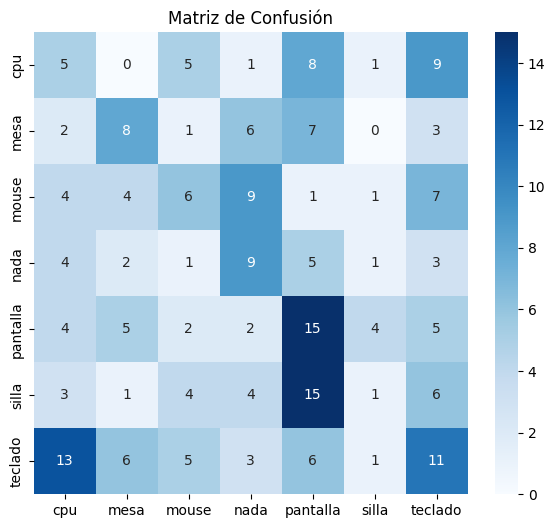

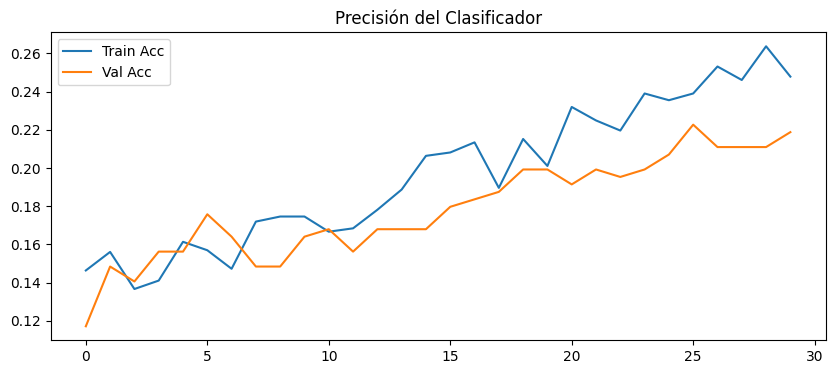

In [14]:
probs = mlp.predict(Xte_emb)
y_pred = probs.argmax(axis=1)

print(classification_report(yte, y_pred, target_names=class_names, digits=3, zero_division=0))

cm = confusion_matrix(yte, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión")
plt.savefig("results/confusion_matrix.png", dpi=300)

plt.figure(figsize=(10,4))
plt.plot(hist_mlp.history['accuracy'], label='Train Acc')
plt.plot(hist_mlp.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Precisión del Clasificador")
plt.savefig("results/accuracy_loss_curves.png", dpi=300)

# 9. GUARDAR EMBEDDINGS PARA VISUALIZACIÓN

In [15]:
np.savez("results/latent_representations.npz",
         Xtr_emb=Xtr_emb, ytr=ytr,
         Xva_emb=Xva_emb, yva=yva,
         Xte_emb=Xte_emb, yte=yte)
print("✅ Representaciones latentes guardadas en /results")

✅ Representaciones latentes guardadas en /results


# 10.  CLASIFICAR IMAGEN NUEVA

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


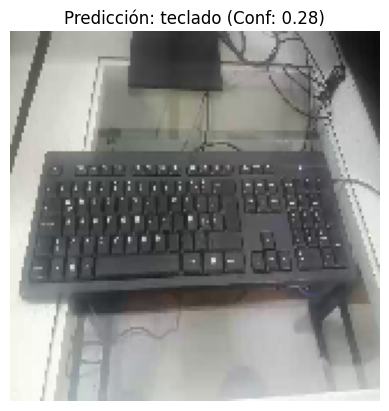

('teclado', np.float32(0.28177497))

In [17]:
from tensorflow.keras.preprocessing import image

def predecir_imagen_autoencoder(img_path, encoder, mlp, class_names, img_size=IMG_SIZE):
    img = image.load_img(img_path, target_size=img_size)
    img_array = np.expand_dims(image.img_to_array(img)/255.0, axis=0)
    z = encoder.predict(img_array)
    probs = mlp.predict(z)
    pred = class_names[np.argmax(probs)]
    conf = np.max(probs)
    plt.imshow(img); plt.axis("off")
    plt.title(f"Predicción: {pred} (Conf: {conf:.2f})")
    plt.show()
    return pred, conf

img_path = "processed/teclado/20251695004_teclado_0001.png"
predecir_imagen_autoencoder(img_path, encoder, mlp, class_names)